### Compare CTSM simulation forced with NLDAS data over Gothic, CO, and billy bar's observations
Created by Will Wieder, Jan 2024


In [1]:
%load_ext autoreload
%autoreload 2

import os
from glob import glob
from os.path import join

import calendar

import tqdm
import cftime
import dask

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.pyplot import cm

from distributed import wait

import warnings
warnings.simplefilter("ignore", category=FutureWarning)

%matplotlib inline

## Open observations from gothic, billy bar data
- Prather, R. M., Inouye, B. D., Underwood, N., Dalton, R., & barr, billy. (2023, June 26). RMBL Weather 1975-2022. https://doi.org/10.17605/OSF.IO/8EZKA
- Dowloaded from https://osf.io/8ezka/ Dec 12, 2023
- Crested Butte weather also avaialbe, but not used here

In [2]:
obs_in = '/glade/campaign/cgd/tss/people/wwieder/obs_dataset/gothic/'
obs_in = obs_in + 'barr-weather-data-1975-2022.csv'
obs_in = pd.read_csv(obs_in).drop(columns=['site'])

In [3]:
#Replace month letter with actual dates
# A = Sept, B=Oct, ect
obs_in = obs_in.replace({"month": {'A':'9', 'B':'10', 'C':'11', 'D':'12', 'E':'1', 'F':'2', 
                                   'G':'3', 'H':'4',  'I':'5' , 'J':'6' , 'K':'7', 'L':'8'}})
obs_in['month'] = pd.to_numeric(obs_in.month)

#create year from snow.year variable 
obs_in['snow_year'] = pd.to_numeric(obs_in['snow.year'].astype(str).str[:4])

# create cumulative sum of precip, 
#   This should = total.water.inches`
obs_in['total.water.cm'] = obs_in['total.water.inches'] * 2.54
obs_in['new.water.cm'] = obs_in['new.water.inches'] * 2.54
obs_in['sum.water.cm'] = obs_in['new.water.cm'].groupby(obs_in['snow_year']).cumsum()

#billy's "snow year" ran from September through August.
# Need to add 1 for Jan-Aug to get calendar year
obs_in['year'] = obs_in['snow_year'].where(obs_in.month>=9,other=obs_in['snow_year']+1)
obs_in[960:975]
obs_in[900:913]
skip=6165
#obs_in[(skip):(15+skip)]
#obs_in.head

In [4]:
# add date.time
obs_in['date'] = pd.to_datetime(dict(year=obs_in.year, month=obs_in.month, day=obs_in.day))
obs_in['day_of_year'] = obs_in['date'].dt.dayofyear
obs_in['day_of_wateryear'] = (obs_in['day_of_year']+365-244).where(obs_in.month<9,other=obs_in['day_of_year']-244)

In [5]:
obs_in.set_index('date', inplace=True)
#obs_in[900:913]
#plt.plot(obs_in['minimum.temperature'])

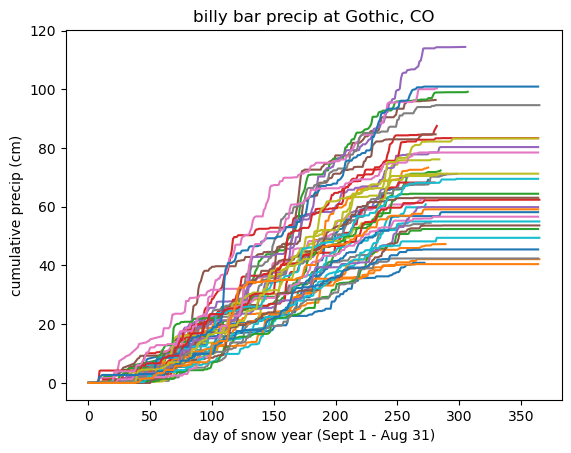

In [6]:
for i in range(1980,2022,1):
    x = obs_in['day_of_wateryear'].where(obs_in['snow_year']==i)
    y = obs_in['sum.water.cm'].where(obs_in['snow_year']==i)
    y2 = obs_in['total.water.cm'].where(obs_in['snow_year']==i)
    plt.plot(x,(y2), label=i)

plt.title('billy bar precip at Gothic, CO')
plt.xlabel('day of snow year (Sept 1 - Aug 31)')
plt.ylabel('cumulative precip (cm)') ;

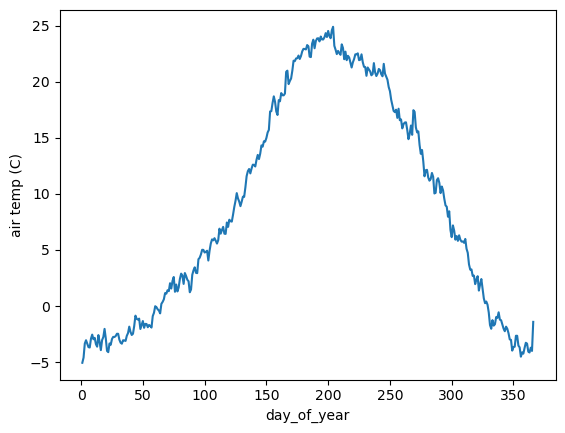

In [7]:
test = obs_in.groupby(obs_in.day_of_year).mean()
#test = obs_in.groupby([(obs_in.index.month), (obs_in.index.day)]).mean()
test['maximum.temperature'].plot() 
plt.ylabel('air temp (C)');

## Read in data from simulations
- test3 = SP simulations with 100% PFT1, needleleaf evergreen tree – temperate
- test2_trans, BGC simulations as above
- also ran with a deciduous boreal tree (aspen), but veg died.


In [8]:
exp = 'test3' # 'test2_trans'
fin = '/glade/campaign/cgd/tss/people/wwieder/cheyenne_archive/nldas/gothic/archive/'+exp+'/lnd/hist/'
fin = [fin+exp+'.clm2.h1.2000-01-01-00000.nc', fin+exp+'.clm2.h1.2010-01-01-00000.nc']
dsHr = xr.open_mfdataset(fin, decode_times=True)
dsHr

<xarray.Dataset>
Dimensions:       (levgrnd: 25, levsoi: 20, levlak: 10, levdcmp: 1,
                   time: 350400, hist_interval: 2, lndgrid: 1)
Coordinates:
  * levgrnd       (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi        (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak        (levlak) float32 0.05 0.6 2.1 4.6 ... 18.6 25.6 34.33 44.78
  * levdcmp       (levdcmp) float32 1.0
  * time          (time) object 2000-01-01 00:00:00 ... 2019-12-31 23:30:28.1...
Dimensions without coordinates: hist_interval, lndgrid
Data variables: (12/31)
    mcdate        (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    mcsec         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    mdcur         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    mscur         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    nstep         (time) int32 dask.array<chunksize=(175200,), meta=np.ndarray>
    time_bounds   (time, hist_interval) object dask.array<chunksize=(175200, 2), meta=np.ndarray>
    ...            ...
    RAIN          (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    SNOW          (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    SNOW_DEPTH    (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    TBOT          (time, lndgrid) float32 dask.array<chunksize=(175200, 1), meta=np.ndarray>
    TSOI          (time, levgrnd, lndgrid) float32 dask.array<chunksize=(175200, 25, 1), meta=np.ndarray>
    H2OSOI        (time, levsoi, lndgrid) float32 dask.array<chunksize=(175200, 20, 1), meta=np.ndarray>
Attributes: (12/39)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 11/17/23 09:43:09
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     minute_30
    Time_constant_3Dvars_filename:        ./test3.clm2.h1.1980-01-01-00000.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

In [9]:
exp = 'evergreen_noLW_sp' 
fin = '/glade/derecho/scratch/wwieder/nldas/gothic/archive/'+exp+'/lnd/hist/'
fin = '/glade/derecho/scratch/wwieder/nldas/gothic/'+exp+'/run/'
fin = [fin+exp+'.clm2.h1.1025-01-01-00000.nc']
dsSP = xr.open_mfdataset(fin, decode_times=True)
exp = 'test3' # used later for plotting


In [10]:
# Convert to C
dsHr['TSOI'] = dsHr.TSOI - 273.15
dsHr['TSOI'].attrs['units'] = 'degC'
dsHr['TBOT'] = dsHr.TBOT - 273.15
dsHr['TBOT'].attrs['units'] = 'degC'

dsSP['TSOI'] = dsSP.TSOI - 273.15
dsSP['TSOI'].attrs['units'] = 'degC'
dsSP['TBOT'] = dsSP.TBOT - 273.15
dsSP['TBOT'].attrs['units'] = 'degC'


In [11]:
ds = dsHr.resample(time="1D").mean()
dsMin = dsHr['TBOT'].resample(time="1D").min()
dsMax = dsHr['TBOT'].resample(time="1D").max()

ds_noLW = dsSP.resample(time="1D").mean()
ds_noLWMin = dsSP['TBOT'].resample(time="1D").min()
ds_noLWMax = dsSP['TBOT'].resample(time="1D").max()

# for wy starting in oct dsWY = ds.shift(time=-273)
shiftWY = -243 #, for OCT = -273
dsWY = ds.shift(time=shiftWY)
dsWY_noLW = ds_noLW.shift(time=shiftWY)

# for plotting water years 
month = [calendar.month_abbr[1:13]]
month_wy = [calendar.month_abbr[9:13]+calendar.month_abbr[1:10]]
dpm = [0, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30 ]
tick = np.cumsum(dpm)
# Starts in Sept, as with billy's data
dpm_wy = [0,30,31,30,31,31,28,31,30,31,30,31,31]
tick_wy = np.cumsum(dpm_wy)

# Check shift sets WY to Sept 1- Aug 31
dsWY.time.shift(time=shiftWY)
dsWY_noLW.time.shift(time=shiftWY)

<xarray.DataArray 'time' (time: 9125)>
array([cftime.DatetimeNoLeap(1025, 9, 1, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1025, 9, 2, 0, 0, 0, 0, has_year_zero=True),
       cftime.DatetimeNoLeap(1025, 9, 3, 0, 0, 0, 0, has_year_zero=True), ...,
       nan, nan, nan], dtype=object)
Coordinates:
  * time     (time) object 1025-01-01 00:00:00 ... 1049-12-31 00:00:00

In [17]:
#### Should add TSA to output files, may be better than TBOT?

<xarray.Dataset>
Dimensions:     (time: 7300, lndgrid: 1, levgrnd: 25, levsoi: 20, levlak: 10,
                 levdcmp: 1)
Coordinates:
  * levgrnd     (levgrnd) float32 0.01 0.04 0.09 0.16 ... 13.33 19.48 28.87 42.0
  * levsoi      (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * levlak      (levlak) float32 0.05 0.6 2.1 4.6 8.1 12.6 18.6 25.6 34.33 44.78
  * levdcmp     (levdcmp) float32 1.0
  * time        (time) object 2000-01-01 00:00:00 ... 2019-12-31 00:00:00
Dimensions without coordinates: lndgrid
Data variables: (12/28)
    mcdate      (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    mcsec       (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    mdcur       (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    mscur       (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    nstep       (time) float64 dask.array<chunksize=(3650,), meta=np.ndarray>
    lon         (time, lndgrid) float32 dask.array<chunksize=(3650, 1), meta=np.ndarray>
    ...          ...
    RAIN        (time, lndgrid) float32 dask.array<chunksize=(3650, 1), meta=np.ndarray>
    SNOW        (time, lndgrid) float32 dask.array<chunksize=(3650, 1), meta=np.ndarray>
    SNOW_DEPTH  (time, lndgrid) float32 dask.array<chunksize=(3650, 1), meta=np.ndarray>
    TBOT        (time, lndgrid) float32 dask.array<chunksize=(3650, 1), meta=np.ndarray>
    TSOI        (time, levgrnd, lndgrid) float32 dask.array<chunksize=(3650, 25, 1), meta=np.ndarray>
    H2OSOI      (time, levsoi, lndgrid) float32 dask.array<chunksize=(3650, 20, 1), meta=np.ndarray>
Attributes: (12/39)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 11/17/23 09:43:09
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     minute_30
    Time_constant_3Dvars_filename:        ./test3.clm2.h1.1980-01-01-00000.nc
    Time_constant_3Dvars:                 ZSOI:DZSOI:WATSAT:SUCSAT:BSW:HKSAT:...

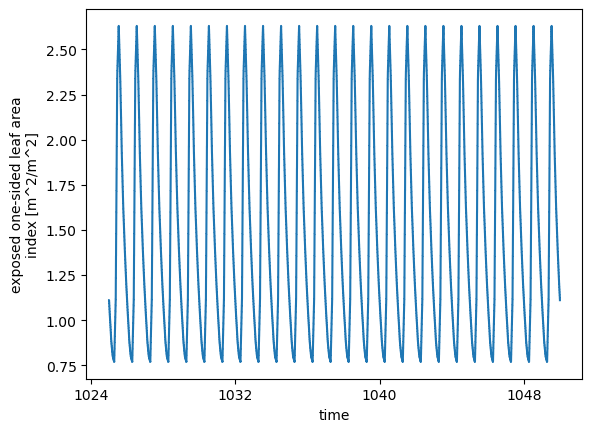

In [23]:
dsSP.ELAI.plot() ;

In [14]:
year = range(2000, 2020)
year_wy = range(2001, 2021)

# Subset observations to the same range
obs = obs_in[obs_in.year>=2000]
obs = obs[obs.year<=2020]
obs['mean_temp'] = (obs['maximum.temperature']+obs['minimum.temperature'])/2

### Make plots comparing model w/ observations

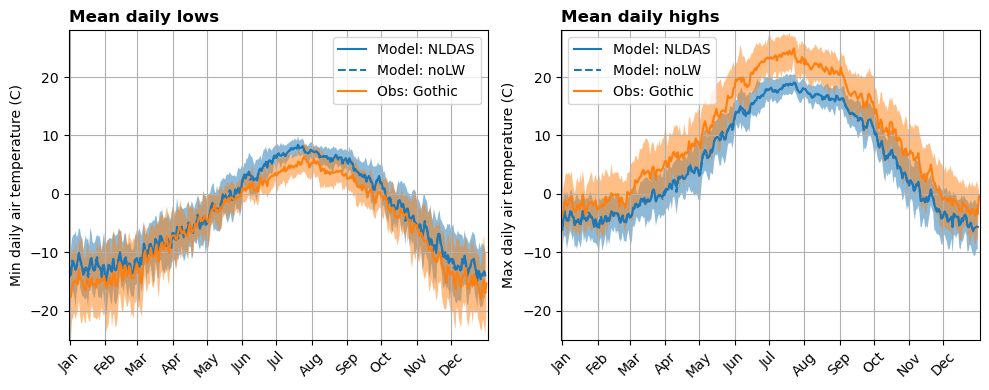

In [16]:
# Calculate climatology
Y1 = obs.groupby(obs.day_of_year).mean()
Y1b = obs.groupby(obs.day_of_year).std()
x1 = range(0,  366)

x2 = range(0,365)

# Plot min and max temperature
obs_var = ['minimum.temperature', 'maximum.temperature']
ylabel = ['Min daily air temperature (C)', 'Max daily air temperature (C)']
title = ['Mean daily lows', 'Mean daily highs']

fig, axes = plt.subplots(1, 2, figsize=(10,4))

for i in range(2):
    if i == 0: 
        Y2 = dsMin.groupby('time.dayofyear').mean().isel(lndgrid=0)
        Y2b = dsMin.groupby('time.dayofyear').std().isel(lndgrid=0)

        Z2 = ds_noLWMin.groupby('time.dayofyear').mean().isel(lndgrid=0)
        Z2b = ds_noLWMin.groupby('time.dayofyear').std().isel(lndgrid=0)
    else:
        Y2 = dsMax.groupby('time.dayofyear').mean().isel(lndgrid=0)
        Y2b = dsMax.groupby('time.dayofyear').std().isel(lndgrid=0)
        Z2 = ds_noLWMax.groupby('time.dayofyear').mean().isel(lndgrid=0)
        Z2b = ds_noLWMax.groupby('time.dayofyear').std().isel(lndgrid=0)

    axes[i].plot(x2, Y2, label = 'Model: NLDAS')
    axes[i].fill_between(x2, Y2-Y2b, Y2+Y2b, alpha=0.5)

    axes[i].plot(x2, Z2, label = 'Model: noLW', color='tab:blue',linestyle="--")
    #axes[i].fill_between(x2, Z2-Z2b, Z2+Z2b, alpha=0.5)

    axes[i].set_xticks(tick, month[0], rotation=45)
    axes[i].set_xlim(-1, 366)
    axes[i].set_ylim(-25, 28)
    
    axes[i].plot(x1, Y1[obs_var[i]], label='Obs: Gothic')
    axes[i].fill_between(x1, Y1[obs_var[i]] - Y1b[obs_var[i]], 
                         Y1[obs_var[i]] + Y1b[obs_var[i]], alpha=0.5)
    axes[i].set_ylabel(ylabel[i])
    axes[i].set_title(title[i],loc='left', fontsize='large', fontweight='bold')
    axes[i].legend()
    axes[i].grid() ;
    
fig.tight_layout()

**Should add TSA to output files, may be better than TBOT?**

#### NLDAS is providing: 
- warm nights (in the summer) and 
- cold days (all year), compared to billy's data

#### Look at water year precip and snow depth 

In [19]:
# cumulative precip from model
dsWY['cumSNOW'] = dsWY['SNOW'].groupby('time.year').cumsum() * 3600 * 24 * 0.1 # convert mm/s to cm/d
dsWY['cumRAIN'] = dsWY['RAIN'].groupby('time.year').cumsum() * 3600 * 24 * 0.1 # convert mm/s to cm/d
dsWY['cumPPT'] = dsWY['cumRAIN'] + dsWY['cumSNOW']

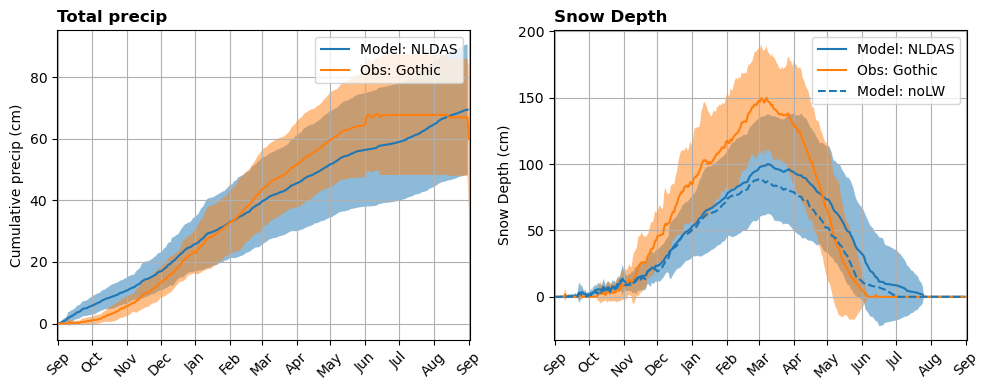

In [20]:
# calculate observed climatology by water year
Y1 = obs.groupby(obs.day_of_wateryear).mean()
Y1b = obs.groupby(obs.day_of_wateryear).std()

# can't compare obs and model snowfall, as the later is in mm of water
clm_var = ['cumPPT','SNOW_DEPTH','cumSNOW']
obs_var = ['sum.water.cm', 'snow.on.ground.cm','total.snow.cm']
ylabel = ['Cumulative precip (cm)', 'Snow Depth (cm)', 'Cumulative snow (cm)']
title = ['Total precip', 'Snow Depth', 'Total snow']

fig, axes = plt.subplots(1, 2, figsize=(10,4))

for i in range(2):
    Y2 = dsWY[clm_var[i]].groupby('time.dayofyear').mean().isel(lndgrid=0)
    Y2b = dsWY[clm_var[i]].groupby('time.dayofyear').std().isel(lndgrid=0)

    if clm_var[i] == 'SNOW_DEPTH':
        Y2 = Y2*100 # convert to cm
        Y2b = Y2b*100 # convert to cm

        Z2 = dsWY_noLW[clm_var[i]].groupby('time.dayofyear').mean().isel(lndgrid=0)
        Z2b = dsWY_noLW[clm_var[i]].groupby('time.dayofyear').std().isel(lndgrid=0)
        Z2 = Z2*100 # convert to cm
        Z2b = Z2b*100 # convert to cm
        
    axes[i].plot(x2,Y2,label='Model: NLDAS')
    axes[i].fill_between(x2, Y2-Y2b, Y2+Y2b, alpha=0.5)
    axes[i].set_xticks(tick_wy, month_wy[0], rotation=45)
    axes[i].set_xlim(-1,366)
    
    axes[i].plot(x1,Y1[obs_var[i]],label='Obs: Gothic')
    axes[i].fill_between(x1, Y1[obs_var[i]]-Y1b[obs_var[i]], 
                         Y1[obs_var[i]]+Y1b[obs_var[i]], alpha=0.5)
    if clm_var[i] == 'SNOW_DEPTH':
        axes[i].plot(x2,Z2,label='Model: noLW', color='tab:blue',linestyle="--")
        #axes[i].fill_between(x2, Z2-Z2b, Z2+Z2b, alpha=0.5)

    axes[i].set_ylabel(ylabel[i])
    axes[i].set_title(title[i],loc='left', fontsize='large', fontweight='bold')
    axes[i].legend() 
    axes[i].grid() ;

fig.tight_layout()

#### Total precip OK? 
- Peak snow depth too low in CLM, maybe SWE OK?
- Snow persists too long in CLM?

---
#### Deeper look at model output

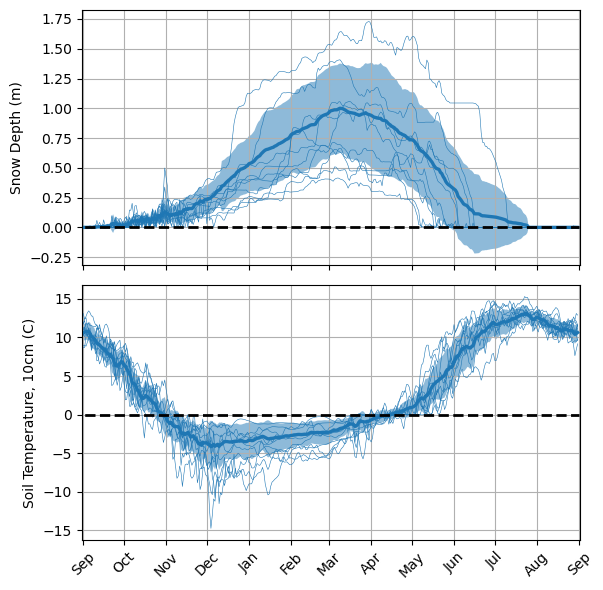

In [21]:
fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True)
var = ['SNOW_DEPTH','TSOI']

yrange = range(9,19)
for v in range(0,2):
    for i in yrange:
        t0 = i*365
        t1 = (i+1)*365
        y = dsWY[var[v]].isel(time=slice(t0,t1)).isel(lndgrid=0)
        if v == 1:
            y = y.isel(levgrnd=2) 
        x = range(0,365)
        axes[v].plot(x,y,lw=0.4,color='tab:blue')#label=str(year_wy[i]))

    y = dsWY[var[v]].groupby('time.dayofyear').mean().isel(lndgrid=0)
    y2 = dsWY[var[v]].groupby('time.dayofyear').std().isel(lndgrid=0)
    if v == 1:
        y = y.isel(levgrnd=2) 
        y2 = y2.isel(levgrnd=2) 

    axes[v].plot(x,y,lw=2.4,color='tab:blue')
    axes[v].fill_between(x, y-y2, y+y2, alpha=0.5)
    axes[v].set_xticks(tick_wy, month_wy[0], rotation=45)
    if v == 0:
        axes[v].set_ylabel('Snow Depth (m)')
    else:
        axes[v].set_ylabel('Soil Temperature, 10cm (C)')
    axes[v].set_xlim(-1,366)
    axes[v].hlines(0,-10,365,color='k',lw=2,linestyles='dashed');
    axes[v].grid() ;
    
fig.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=1) ;

/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/flox/aggregations.py:307: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(_var_finalize(sumsq, sum_, count, ddof))
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/flox/aggregations.py:307: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(_var_finalize(sumsq, sum_, count, ddof))
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/flox/aggregations.py:307: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(_var_finalize(sumsq, sum_, count, ddof))
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/flox/aggregations.py:307: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(_var_finalize(sumsq, sum_, count, ddof))
/glade/u/apps/opt/conda/envs/npl-2023b/lib/python3.10/site-packages/flox/aggregations.py:307: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(_var_finalize(sumsq, sum_, coun

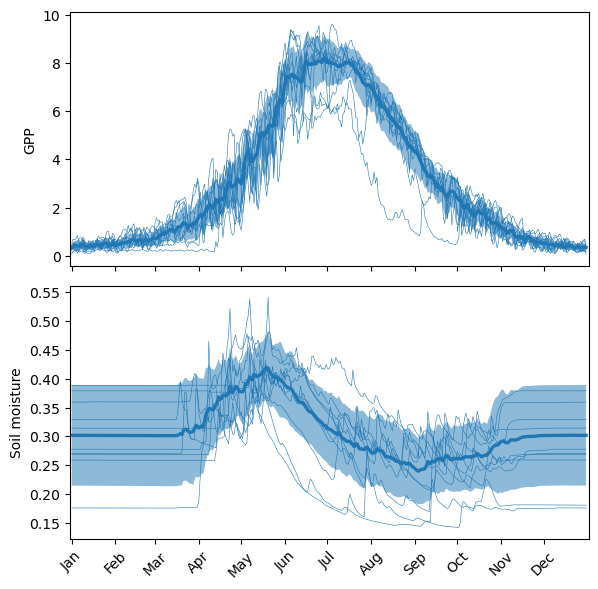

In [26]:
fig, axes = plt.subplots(2, 1, figsize=(6,6), sharex=True)
if exp == 'test3':
    var = ['FPSN','H2OSOI']
else :
    var = ['GPP','H2OSOI']
    
#yrange = range(9,19)
for v in range(0,2):
    for i in yrange:
        t0 = i*365
        t1 = (i+1)*365
        y = ds[var[v]].isel(time=slice(t0,t1)).isel(lndgrid=0)
        if v == 1:
            y = y.isel(levsoi=2) 
        x = range(0,365)
        axes[v].plot(x,y,lw=0.4,color='tab:blue')#label=str(year_wy[i]))

    y = ds[var[v]].groupby('time.dayofyear').mean().isel(lndgrid=0)
    y2 = ds[var[v]].groupby('time.dayofyear').std().isel(lndgrid=0)
    if v == 1:
        y = y.isel(levsoi=2) 
        y2 = y2.isel(levsoi=2) 

    axes[v].plot(x,y,lw=2.4,color='tab:blue')
    axes[v].fill_between(x, y-y2, y+y2, alpha=0.5)
    axes[v].set_xticks(tick, month[0], rotation=45)
    if v == 0:
        axes[v].set_ylabel('GPP')
    else:
        axes[v].set_ylabel('Soil moisture')
    axes[v].set_xlim(-1,366)

fig.tight_layout()
#plt.subplots_adjust(wspace=0, hspace=1) ;

### How is interannual variability:
- Look at invidual years

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


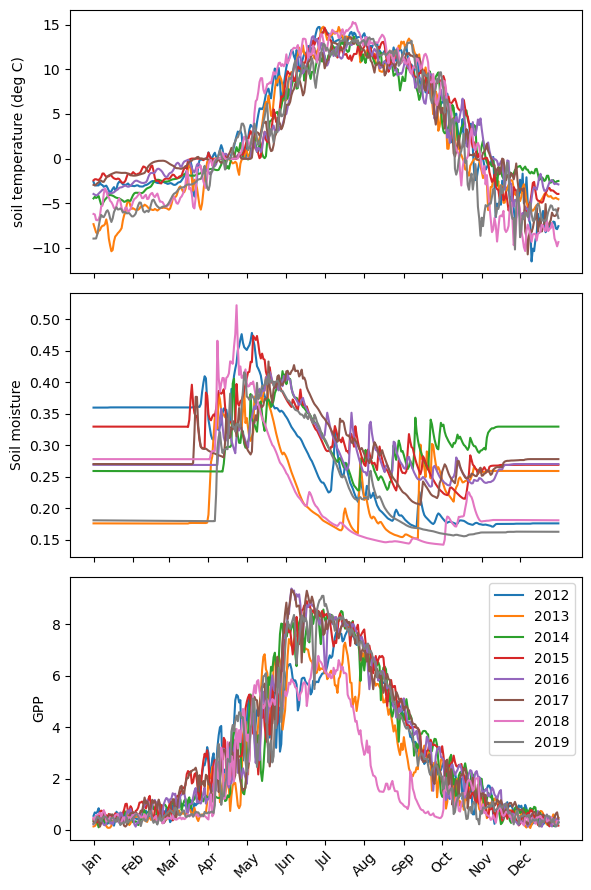

In [27]:
fig, axes = plt.subplots(3, 1, figsize=(6,9), sharex=True)
    
yrange = range(12,20)
for v in range(3):
    for i in yrange:
        t0 = i*365
        t1 = (i+1)*365
        if v == 0:
            y = ds.TSOI.isel(time=slice(t0,t1),levgrnd=2)
        if v == 1:
            y = ds.H2OSOI.isel(time=slice(t0,t1),levsoi=2)
        if v == 2:
            y = ds.FPSN.isel(time=slice(t0,t1))
            
        x = range(0,365)
        axes[v].plot(x,y,label=str(year[i]))
        axes[v].set_xticks(tick, month[0], rotation=45)
        
    axes[0].set_ylabel('soil temperature (deg C)')
    axes[1].set_ylabel('Soil moisture')
    axes[2].set_ylabel('GPP')
    plt.legend() ;

fig.tight_layout()


#### Driest years = 2012, 2013, 2018

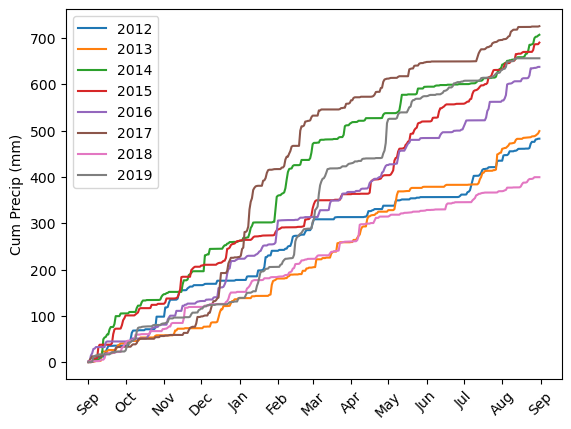

In [28]:
yrange = range(0,19)
spd = 3600*24
dsWY['PRECIP'] = (dsWY.SNOW + dsWY.RAIN)
WATERYEAR = np.empty(19)
RAIN = np.empty(19)
SNOW = np.empty(19)
for i in yrange:
    t0 = i*365
    t1 = (i+1)*365
    y = dsWY.PRECIP.isel(time=slice(t0,t1)).cumsum()*spd
    WATERYEAR[i] = int(year_wy[i])
    SNOW[i] = ((dsWY.SNOW.isel(time=slice(t0,t1)).cumsum()*spd).max().values)
    RAIN[i] = ((dsWY.RAIN.isel(time=slice(t0,t1)).cumsum()*spd).max().values)
    x = range(0,365)
    if i>10:
        plt.plot(x,y,label=str(year_wy[i]))
    
plt.xticks(tick_wy, month_wy[0], rotation=45)
plt.ylabel('Cum Precip (mm)')
plt.legend() ;

TOTAL = RAIN+SNOW

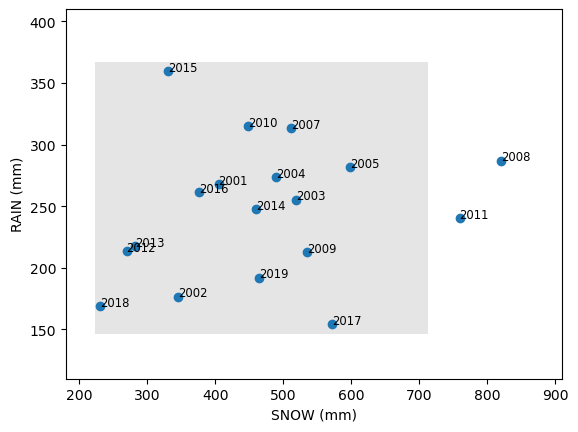

In [29]:
meanSNOW = SNOW.mean()
stdSNOW = SNOW.std()*1.644
meanRAIN = RAIN.mean()
stdRAIN = RAIN.std()*1.644

left, bottom, width, height = ((meanSNOW-stdSNOW), (meanRAIN-stdRAIN), 
                               (2*stdSNOW), (2*stdRAIN))
rect = plt.Rectangle((left, bottom), width, height,
                     facecolor="black", alpha=0.1)

fig, ax = plt.subplots()
ax.add_patch(rect)
ax.scatter(SNOW,RAIN)

for i, txt in enumerate(WATERYEAR.astype(int)):
    ax.annotate(txt, (SNOW[i],RAIN[i]), fontsize='small')
plt.xlabel('SNOW (mm)')
plt.ylabel('RAIN (mm)')
plt.xlim(180,910)
plt.ylim(110,410)

plt.show()

#### How does this compare with Mariah's 2023 paper?

----

#### Look a depth profiles of soil moisture
- likely need to adjust soil depth and properties for sites?

In [30]:
ds.levsoi.attrs = []
ds.H2OSOI.attrs['long_name'] = 'volumetric soil water'

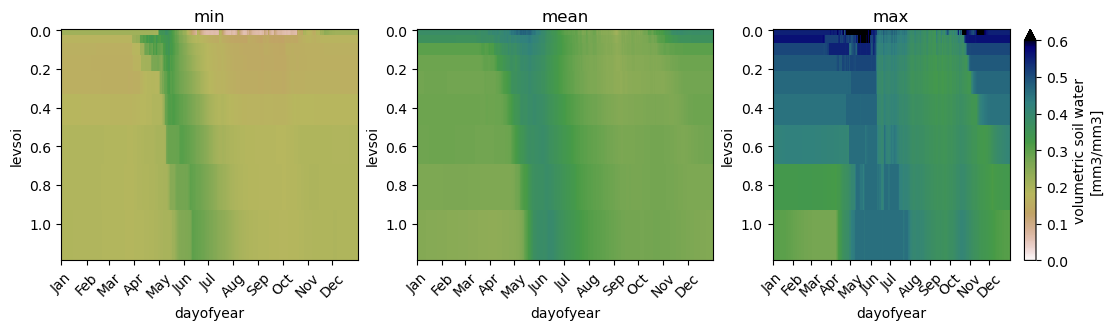

In [31]:
plt.figure(figsize=[13,3])
plt.subplot(1, 3, 1)
ds.H2OSOI.groupby('time.dayofyear').min().isel(
    lndgrid=0,levsoi=slice(0,9)).plot(
    x='dayofyear',robust=True,vmin=0.0,vmax=0.6,cmap='gist_earth_r',add_colorbar=False)
plt.gca().invert_yaxis() ;
plt.xticks(tick, month[0], rotation=45) ;
plt.title('min')

plt.subplot(1, 3, 2)
ds.H2OSOI.groupby('time.dayofyear').mean().isel(
    lndgrid=0,levsoi=slice(0,9)).plot(
    x='dayofyear',vmin=0.0,vmax=0.6,cmap='gist_earth_r',add_colorbar=False)
plt.gca().invert_yaxis() ;
plt.xticks(tick, month[0], rotation=45) ;
plt.title('mean')

plt.subplot(1, 3, 3)
ds.H2OSOI.groupby('time.dayofyear').max().isel(
    lndgrid=0,levsoi=slice(0,9)).plot(
    x='dayofyear',robust=True,vmin=0.0,vmax=0.6,cmap='gist_earth_r')
plt.gca().invert_yaxis() ;
plt.xticks(tick, month[0], rotation=45) ;
plt.title('max')

fig.tight_layout()


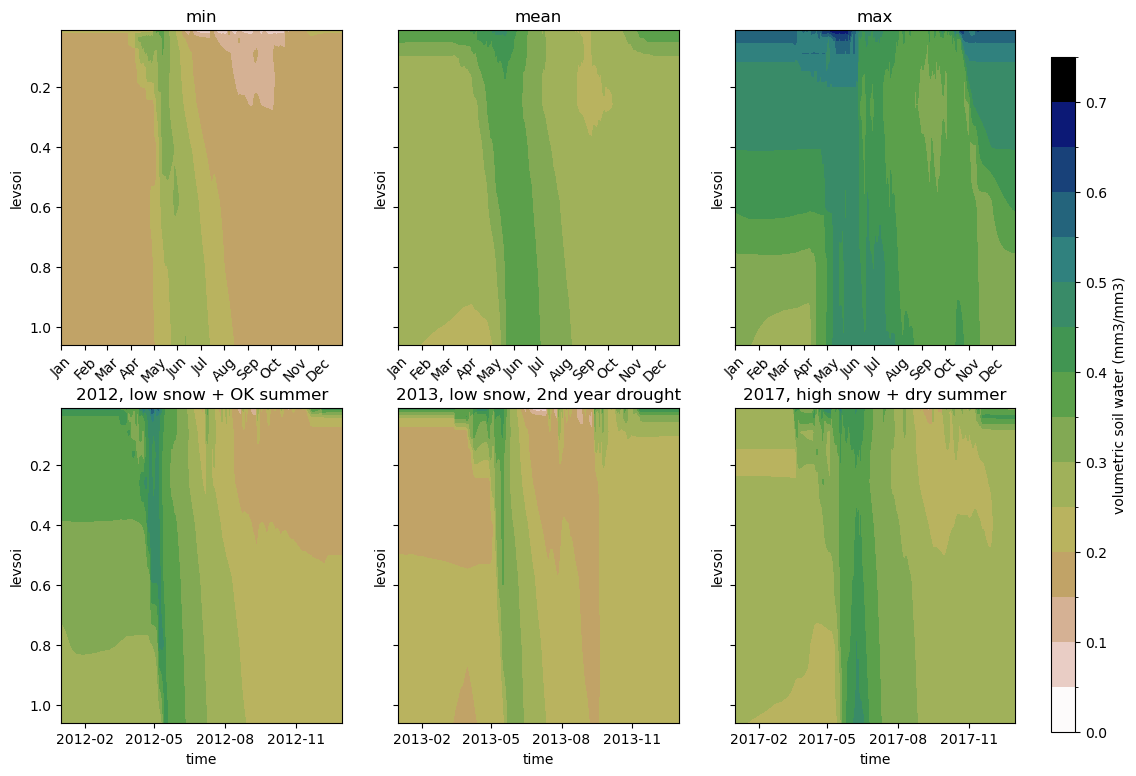

In [32]:
fig, axs = plt.subplots(ncols=3, nrows=2,
                        figsize=(12,9),
                        sharey=True)
[ax1, ax2, ax3],[ax4, ax5, ax6] = axs

vmin=0.05
vmax=0.75
levels=[0,  0.05,0.1,0.15,0.2,0.25,0.3,0.35,
        0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75]
cmap='gist_earth_r'

a = ds.H2OSOI.groupby('time.dayofyear').min().isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax1,  x='dayofyear',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax1.set_xticks(tick, month[0], rotation=45) ;
ax1.set_title('min')
ax1.set_xlabel(None)

a = ds.H2OSOI.groupby('time.dayofyear').mean().isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax2,  x='dayofyear',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax2.set_xticks(tick, month[0], rotation=45) ;
ax2.set_title('mean') ;
ax2.set_xlabel(None)

a = ds.H2OSOI.groupby('time.dayofyear').max().isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax3,  x='dayofyear',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax3.set_xticks(tick, month[0], rotation=45) ;
ax3.set_title('max') ;
ax3.set_xlabel(None)

a = ds.H2OSOI.sel(time=ds.time.dt.year.isin([2012])).isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax4,  x='time',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax4.set_title('2012, low snow + OK summer') ;

a = ds.H2OSOI.sel(time=ds.time.dt.year.isin([2013])).isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax5,  x='time',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax5.set_title('2013, low snow, 2nd year drought') ;

a = ds.H2OSOI.sel(time=ds.time.dt.year.isin([2017])).isel(
    lndgrid=0,levsoi=slice(0,9)).plot.contourf(ax=ax6,  x='time',levels=levels,
                                               vmin=vmin,vmax=vmax,cmap=cmap,add_colorbar = False)
ax6.set_title('2017, high snow + dry summer') ;

plt.gca().invert_yaxis() ;
fig.subplots_adjust(right=.92) #also try using kwargs bottom, top, or hspace 
cbar_ax = fig.add_axes([0.95, 0.1, .02, .75]) #left, bottom, width, height
fig.colorbar(a, cax=cbar_ax, orientation="vertical", 
             label=ds.H2OSOI.attrs['long_name']+" ("+ds.H2OSOI.attrs['units']+")") ;